In [1]:
import torch
import torchvision.models as model
import timm
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms,datasets
import os
import glob
from tqdm import tqdm
from PIL import Image
import random
from sklearn.model_selection import train_test_split
import torch
import cv2

import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import random
from tqdm import tqdm

In [2]:
Model = timm.create_model('resnet18', pretrained=True, num_classes=8)

In [3]:
class load_data(Dataset):
    def __init__(self, path):
        self.img_list = glob.glob(path)        

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        img_name = self.img_list[index]
        ret_img = cv2.imread(img_name)
        ret_coord = img_name.split('/')[-1]
        ret_coord = ret_coord.split(".jpg")[0]
        ret_coord = ret_coord.replace("__", "_")
        ret_coord = list(map(float, ret_coord.split("_")))
        tp = random.randint(1,5) # related to shearing
        tp2 = random.randint(1,4) # related to brightness
        # shear transformation
        if tp==1:# shearing with y1
            ret_img, ret_coord = self.shear_y1(ret_img, ret_coord)
            #elf.visualization(ret_img, ret_coord)
        elif tp==2:# shearing with y2
            ret_img, ret_coord = self.shear_y2(ret_img, ret_coord)
            #elf.visualization(ret_img, ret_coord)
        elif tp==3:# shearing with x1
            ret_img, ret_coord = self.shear_x1(ret_img, ret_coord)
            #self.visualization(ret_img, ret_coord)
        elif tp==4:# shearing with x2
            ret_img, ret_coord = self.shear_x2(ret_img, ret_coord)
            #elf.visualization(ret_img, ret_coord)
        else:# no shaering
            ret_img, ret_coord = self.original(ret_img, ret_coord)
            #elf.visualization(ret_img, ret_coord)
        ret_img = cv2.resize(ret_img, dsize=(128, 128))
#         plt.imshow(ret_img)
#         plt.show()
        # brightness augmentation
        #tp2 = 4
        if tp2 == 1: # no augmentation
            pass
        elif tp2 == 2: # whole brighten
            rnd_b = int(random.uniform(0, 50))
            array = np.full(ret_img.shape, (rnd_b, rnd_b, rnd_b), dtype = np.uint8)
            ret_img = cv2.add(ret_img, array)
        elif tp2 == 3: # whole darken
            rnd_b = int(random.uniform(0, 60))
            array = np.full(ret_img.shape, (rnd_b, rnd_b, rnd_b), dtype = np.uint8)
            ret_img = cv2.subtract(ret_img, array)

        else: # horizontal shadow (always the upper the darker because of shadow)
            rnd_cover = int(random.uniform(54, 74))
            rnd_step = int(random.uniform(13, 50))
            rnd_tilt = int(random.randint(-1, 1))

            mask_cover = rnd_cover
            mask = np.zeros(ret_img.shape[0:2], dtype = np.uint8) # (128, 256)

            for col in range(mask.shape[1]):
                for row in range(mask.shape[0]):
                    if row <= mask_cover:
                        mask[row][col] = 255
                if (col + 1) % rnd_step == 0:
                    mask_cover = mask_cover + rnd_tilt
            rnd_b = int(random.uniform(0, 50))
            array = np.full(ret_img.shape, (rnd_b, rnd_b, rnd_b), dtype=np.uint8)
            shadowed = cv2.subtract(ret_img, array, mask = mask)
            for row in range(shadowed.shape[0]):
                for col in range(shadowed.shape[1]):
                    if shadowed[row][col][0] == 0:
                        shadowed[row][col] = ret_img[row][col]
            ret_img = shadowed
        ret_img = ret_img / 255.0
        ret_coord = np.array(ret_coord)
        ret_img = ret_img.transpose((2, 0, 1))
        
        return ret_img, ret_coord, tp
    ########################################################################################################
    def visualization(self, input_img, coord, color=(0, 0, 255)):
        h, w = input_img.shape[:2]
        coord_list = [(int(w * coord[0]), int(h * coord[1])),
                      (int(w * coord[2]), int(h * coord[3])),
                      (int(w * coord[4]), int(h * coord[5])),
                      (int(w * coord[6]), int(h * coord[7]))]
        return coord_list
    ########################################################################################################
    def shear_y1(self, input_img, ret_coord):
        src = input_img
        h, w = src.shape[:2]
        # shear 주는 정도
        degree = random.uniform(0,0.5)
        degree = round(degree, 2)
        #image shearing
        affy =  np.array([[1, 0, 0],[degree, 1, 0]], dtype=np.float32)
        dsty = cv2.warpAffine(src, affy, (w, h+ int(w * degree)))
        # 좌표 shearing
        hw = np.array([[w, 0],[0,h]])
        ret_coord = np.reshape(ret_coord, (4,2))
        r = np.dot(ret_coord, hw)
        nh, nw = dsty.shape[:2]
        r = [[r[0][0],r[0][1]+r[0][0]*degree], [r[1][0],r[1][1]+r[1][0]*degree], [r[2][0],r[2][1]+r[2][0]*degree], [r[3][0],r[3][1]+r[3][0]*degree]]
        r = [[r[0][0]/nw,r[0][1]/nh], [r[1][0]/nw,r[1][1]/nh], [r[2][0]/nw,r[2][1]/nh], [r[3][0]/nw,r[3][1]/nh]]
        ret_coord2 = np.array([r[0][0],r[0][1],r[1][0],r[1][1],r[2][0],r[2][1],r[3][0],r[3][1]])
        coord = self.visualization(dsty, ret_coord2)
        coord_x = []
        coord_y = []
        for i in coord:
            coord_x.append(i[0])
            coord_y.append(i[1])
        min_x = min(coord_x);min_y = min(coord_y)
        max_x = max(coord_x);max_y = max(coord_y)
        # cropped image의 padding
        pad_xr = nw*(random.uniform(0.01, 0.03))
        pad_xl = nw*(random.uniform(0.01, 0.03))
        pad_yu = nh*(random.uniform(0.005, 0.015))
        pad_yd = nh*(random.uniform(0.005, 0.015))
    
        cropped_img = dsty[int(min_y-pad_yu): int(min_y-pad_yu + max_y-min_y+pad_yu+pad_yd), int(min_x-pad_xl): int(min_x-pad_xl + max_x-min_x+pad_xr+pad_xl)]
    
        coord_x = list(map(lambda x: x -int(min_x-pad_xl), coord_x))
        coord_y = list(map(lambda x: x- int(min_y-pad_yu), coord_y))
        new_coord = []
        h2, w2 = cropped_img.shape[:2]
        for i in range(4):
            new_coord.append(coord_x[i]/w2)
            new_coord.append(coord_y[i]/h2)
        return cropped_img, new_coord
    ########################################################################################################
    def shear_y2(self, input_img, ret_coord):
        src = input_img
        h, w = src.shape[:2]
        # shear 주는 정도
        degree = random.uniform(-0.5,0)
        degree = round(degree, 2)
        # image shearing
        affy =  np.array([[1, 0, 0],[degree, 1, -degree*w]], dtype=np.float32)
        degree = -degree
        dsty = cv2.warpAffine(src, affy, (w, h+ int(w * degree)))
        # 좌표 shearing
        hw = np.array([[w, 0],[0,h]])
        ret_coord = np.reshape(ret_coord, (4,2))
        nh, nw = dsty.shape[:2]
        degree = -degree
        r = np.dot(ret_coord, hw)
        r = [[r[0][0],r[0][1]+r[0][0]*degree-degree*w], [r[1][0],r[1][1]+r[1][0]*degree-degree*w], [r[2][0],r[2][1]+r[2][0]*degree-degree*w], [r[3][0],r[3][1]+r[3][0]*degree-degree*w]]
        r = [[r[0][0]/nw,r[0][1]/nh], [r[1][0]/nw,r[1][1]/nh], [r[2][0]/nw,r[2][1]/nh], [r[3][0]/nw,r[3][1]/nh]]
        ret_coord2 = np.array([r[0][0],r[0][1],r[1][0],r[1][1],r[2][0],r[2][1],r[3][0],r[3][1]])
        #print(ret_coord2)
        coord = self.visualization(dsty, ret_coord2)
        coord_x = []
        coord_y = []
        for i in coord:
            coord_x.append(i[0])
            coord_y.append(i[1])
        min_x = min(coord_x);min_y = min(coord_y)
        max_x = max(coord_x);max_y = max(coord_y)
       # cropped image의 padding
        pad_xr = nw*(random.uniform(0.01, 0.03))
        pad_xl = nw*(random.uniform(0.01, 0.03))
        pad_yu = nh*(random.uniform(0.005, 0.015))
        pad_yd = nh*(random.uniform(0.005, 0.015))
        cropped_img = dsty[int(min_y-pad_yu): int(min_y-pad_yu + max_y-min_y+pad_yu+pad_yd), int(min_x-pad_xl): int(min_x-pad_xl + max_x-min_x+pad_xr+pad_xl)]
        coord_x = list(map(lambda x: x -int(min_x-pad_xl), coord_x))
        coord_y = list(map(lambda x: x- int(min_y-pad_yu), coord_y))
        new_coord = []
        h2, w2 = cropped_img.shape[:2]
        for i in range(4):
            new_coord.append(coord_x[i]/w2)
            new_coord.append(coord_y[i]/h2)
        return cropped_img, new_coord
    ########################################################################################################
    def shear_x1(self, input_img, ret_coord):
        src = input_img
        h,w = src.shape[:2]
        # shear 주는 정도
        degree = random.uniform(0,0.5)
        degree = round(degree, 2)
        # image shearing
        affx =  np.array([[1, degree, 0],[0, 1, 0]], dtype=np.float32)
        dstx = cv2.warpAffine(src, affx, (w+ int(h * degree), h))
        # 좌표 shearing
        hw = np.array([[w, 0],[0,h]])
        ret_coord = np.reshape(ret_coord, (4,2))
        nh, nw = dstx.shape[:2]
        r = np.dot(ret_coord, hw)
        r = [[r[0][0]+r[0][1]*degree,r[0][1]], [r[1][0]+r[1][1]*degree,r[1][1]], [r[2][0]+r[2][1]*degree,r[2][1]], [r[3][0]+r[3][1]*degree,r[3][1]]]
        r = [[r[0][0]/nw,r[0][1]/nh], [r[1][0]/nw,r[1][1]/nh], [r[2][0]/nw,r[2][1]/nh], [r[3][0]/nw,r[3][1]/nh]]
        ret_coord2 = np.array([r[0][0],r[0][1],r[1][0],r[1][1],r[2][0],r[2][1],r[3][0],r[3][1]])
        coord = self.visualization(dstx, ret_coord2)
        coord_x = []
        coord_y = []
        for i in coord:
            coord_x.append(i[0])
            coord_y.append(i[1])
        min_x = min(coord_x);min_y = min(coord_y)
        max_x = max(coord_x);max_y = max(coord_y)
        # cropped image의 padding
        pad_xr = nw*(random.uniform(0.01, 0.03))
        pad_xl = nw*(random.uniform(0.01, 0.03))
        pad_yu = nh*(random.uniform(0.005, 0.015))
        pad_yd = nh*(random.uniform(0.005, 0.015))
        cropped_img = dstx[int(min_y-pad_yu): int(min_y-pad_yu + max_y-min_y+pad_yu+pad_yd), int(min_x-pad_xl): int(min_x-pad_xl + max_x-min_x+pad_xr+pad_xl)]
        coord_x = list(map(lambda x: x -int(min_x-pad_xl), coord_x))
        coord_y = list(map(lambda x: x- int(min_y-pad_yu), coord_y))
        new_coord = []
        h2, w2 = cropped_img.shape[:2]
        for i in range(4):
            new_coord.append(coord_x[i]/w2)
            new_coord.append(coord_y[i]/h2)
        return cropped_img, new_coord
    ########################################################################################################
    def shear_x2(self, input_img, ret_coord):
        src = input_img
        h, w = src.shape[:2]
        # shear 주는 정도
        degree = random.uniform(-0.5,0)
        degree = round(degree, 2)
        # image shearing
        affx =  np.array([[1, degree, -degree*h],[0, 1, 0]], dtype=np.float32)
        degree = -degree
        dstx = cv2.warpAffine(src, affx, (w+ int(h * degree), h))
        # 좌표 shearing
        hw = np.array([[w, 0],[0,h]])
        ret_coord = np.reshape(ret_coord, (4,2))
        nh, nw = dstx.shape[:2]
        degree = -degree
        r = np.dot(ret_coord, hw)
        r = [[r[0][0]+r[0][1]*degree -degree*h,r[0][1]], [r[1][0]+r[1][1]*degree -degree*h,r[1][1]], [r[2][0]+r[2][1]*degree -degree*h,r[2][1]], [r[3][0]+r[3][1]*degree -degree*h,r[3][1]]]
        r = [[r[0][0]/nw,r[0][1]/nh], [r[1][0]/nw,r[1][1]/nh], [r[2][0]/nw,r[2][1]/nh], [r[3][0]/nw,r[3][1]/nh]]
        ret_coord2 = np.array([r[0][0],r[0][1],r[1][0],r[1][1],r[2][0],r[2][1],r[3][0],r[3][1]])
        coord = self.visualization(dstx, ret_coord2)
        coord_x = []
        coord_y = []
        for i in coord:
            coord_x.append(i[0])
            coord_y.append(i[1])
        min_x = min(coord_x);min_y = min(coord_y)
        max_x = max(coord_x);max_y = max(coord_y)
        # cropped image의 padding
        pad_xr = nw*(random.uniform(0.01, 0.03))
        pad_xl = nw*(random.uniform(0.01, 0.03))
        pad_yu = nh*(random.uniform(0.005, 0.015))
        pad_yd = nh*(random.uniform(0.005, 0.015))
        cropped_img = dstx[int(min_y-pad_yu): int(min_y-pad_yu + max_y-min_y+pad_yu+pad_yd), int(min_x-pad_xl): int(min_x-pad_xl + max_x-min_x+pad_xr+pad_xl)]
        coord_x = list(map(lambda x: x -int(min_x-pad_xl), coord_x))
        coord_y = list(map(lambda x: x- int(min_y-pad_yu), coord_y))
        new_coord = []
        h2, w2 = cropped_img.shape[:2]
        for i in range(4):
            new_coord.append(coord_x[i]/w2)
            new_coord.append(coord_y[i]/h2)
        return cropped_img, new_coord
    ########################################################################################################
    def original(self, input_img, ret_coord):
        src = input_img
        h, w = src.shape[:2]
        coord = self.visualization(src, ret_coord)
        coord_x = []
        coord_y = []
        for i in coord:
            coord_x.append(i[0])
            coord_y.append(i[1])
        min_x = min(coord_x);min_y = min(coord_y)
        max_x = max(coord_x);max_y = max(coord_y)
        # cropped image의 padding
        pad_xr = w*(random.uniform(0.01, 0.03))
        pad_xl = w*(random.uniform(0.01, 0.03))
        pad_yu = h*(random.uniform(0.005, 0.015))
        pad_yd = h*(random.uniform(0.005, 0.015))
        cropped_img = src[int(min_y-pad_yu): int(min_y-pad_yu + max_y-min_y+pad_yu+pad_yd), int(min_x-pad_xl): int(min_x-pad_xl + max_x-min_x+pad_xr+pad_xl)]
        coord_x = list(map(lambda x: x -int(min_x-pad_xl), coord_x))
        coord_y = list(map(lambda x: x- int(min_y-pad_yu), coord_y))
        new_coord = []
        h2, w2 = cropped_img.shape[:2]
        for i in range(4):
            new_coord.append(coord_x[i]/w2)
            new_coord.append(coord_y[i]/h2)
        return cropped_img, new_coord

In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def visualization(img: torch.Tensor, coord:torch.Tensor, color=(0, 255, 0)):
    input_img = np.array((img.cpu().detach().numpy().transpose((1, 2, 0)) * 255.0)).astype(np.uint8) # (128, 128, 3)
    coord = coord.cpu().detach().numpy() # (8,)


    coord_list = [(int(128 * coord[0]), int(128 * coord[1])),
                  (int(coord[2] * 128), int(128 * coord[3])),
                  (int(128 * coord[4]), int(128 * coord[5])),
                  (int(128 * coord[6]), int(128 * coord[7]))]

    image = cv2.cvtColor(np.array(input_img), cv2.COLOR_BGR2RGB)
    img = cv2.line(image, coord_list[0], coord_list[1], color=color)
    img = cv2.line(img, coord_list[1], coord_list[2], color=color)
    img = cv2.line(img, coord_list[2], coord_list[3], color=color)
    img = cv2.line(img, coord_list[3], coord_list[0], color=color)
    

    print("visualizing...")
    plt.imshow(img[:,:,::-1])
    plt.show()



In [5]:
class ValidationDataset(Dataset):
    def __init__(self, path):
        self.img_list = glob.glob(path)

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        img_name = self.img_list[index]
        ret_coord = img_name.split('/')[-1]
        ret_coord = ret_coord.split(".jpg")[0]
        ret_coord = ret_coord.replace("__", "_")
        ret_coord = np.array(list(map(float, ret_coord.split("_"))))
        ret_img = cv2.imread(img_name)
        
        ret_img, ret_coord = self.original(ret_img, ret_coord)
        ret_img = cv2.resize(ret_img, (128, 128)) / 255.0
        ret_img = ret_img.transpose((2, 0, 1))
        ret_coord = np.array(ret_coord)
        # ret_label = img_name.split("__")
        return ret_img, ret_coord
    
    def original(self, input_img, ret_coord):
        src = input_img
        h, w = src.shape[:2]
        coord = self.visualization(src, ret_coord)
        coord_x = []
        coord_y = []
        for i in coord:
            coord_x.append(i[0])
            coord_y.append(i[1])
        min_x = min(coord_x);min_y = min(coord_y)
        max_x = max(coord_x);max_y = max(coord_y)
        # cropped image의 padding
        pad_xr = w*(random.uniform(0.01, 0.03))
        pad_xl = w*(random.uniform(0.01, 0.03))
        pad_yu = h*(random.uniform(0.005, 0.015))
        pad_yd = h*(random.uniform(0.005, 0.015))
        cropped_img = src[int(min_y-pad_yu): int(min_y-pad_yu + max_y-min_y+pad_yu+pad_yd), int(min_x-pad_xl): int(min_x-pad_xl + max_x-min_x+pad_xr+pad_xl)]
        coord_x = list(map(lambda x: x -int(min_x-pad_xl), coord_x))
        coord_y = list(map(lambda x: x- int(min_y-pad_yu), coord_y))
        new_coord = []
        h2, w2 = cropped_img.shape[:2]
        for i in range(4):
            new_coord.append(coord_x[i]/w2)
            new_coord.append(coord_y[i]/h2)
        return cropped_img, new_coord
    def visualization(self, input_img, coord, color=(0, 0, 255)):
        h, w = input_img.shape[:2]
        coord_list = [(int(w * coord[0]), int(h * coord[1])),
                      (int(w * coord[2]), int(h * coord[3])),
                      (int(w * coord[4]), int(h * coord[5])),
                      (int(w * coord[6]), int(h * coord[7]))]
        return coord_list

In [6]:
train_path = './donghee/train/*.jpg'
test_path =  './donghee/val/*.jpg'
train_dataset = load_data(train_path)
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle=True, num_workers = 4, pin_memory=True)

test_dataset = ValidationDataset(test_path)
test_loader = DataLoader(test_dataset, batch_size=64, num_workers = 4, pin_memory=True)

In [7]:
# L1Loss

epoch = 256
device = torch.device('cuda')
Model.cuda()
criterion = nn.L1Loss()
optimizer = torch.optim.SGD(Model.parameters(), lr=0.05, momentum=0.9, nesterov=True)
x = torch.randn(64, 3, 128, 128, requires_grad = True).cuda() #dummy input
best = 10000
count = 0


::::Train::::


100%|██████████| 26/26 [01:38<00:00,  3.81s/it]

0.11866854283423234
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.57s/it]


smaller rmse, saving model weights...
best:  10000 current rmse:  0.08522506
epoch0 end
::::Train::::



  0%|          | 0/26 [00:00<?, ?it/s]

visualizing...


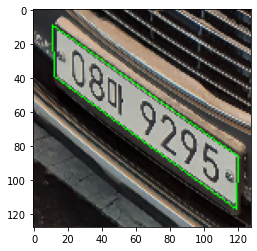

visualizing...


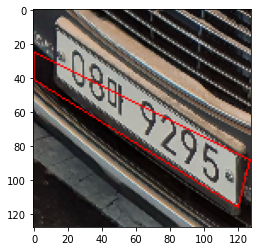

100%|██████████| 26/26 [01:43<00:00,  3.98s/it]

0.06964795260892366
::::Validation::::



  0%|          | 0/7 [00:00<?, ?it/s]

visualizing...


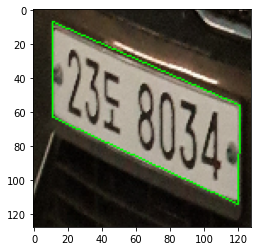

visualizing...


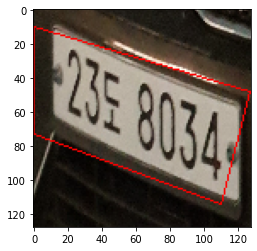

100%|██████████| 7/7 [00:23<00:00,  3.42s/it]


smaller rmse, saving model weights...
best:  0.08522506 current rmse:  0.08348672
epoch1 end
::::Train::::



  0%|          | 0/26 [00:00<?, ?it/s]

visualizing...


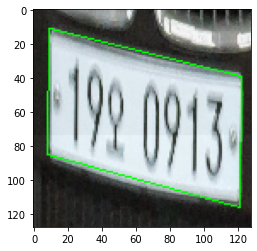

visualizing...


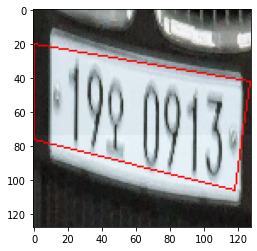

100%|██████████| 26/26 [01:42<00:00,  3.95s/it]

0.060962537167998265
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.50s/it]


smaller rmse, saving model weights...
best:  0.08348672 current rmse:  0.07288851
epoch2 end
::::Train::::



  0%|          | 0/26 [00:00<?, ?it/s]

visualizing...


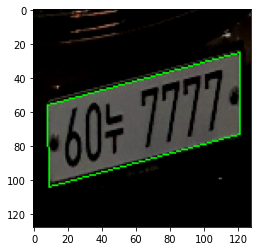

visualizing...


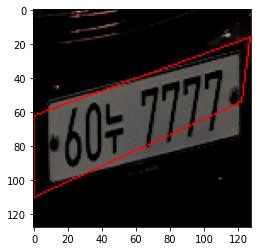

100%|██████████| 26/26 [01:43<00:00,  3.98s/it]

0.054559810653283324
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.49s/it]

epoch3 end
::::Train::::



  0%|          | 0/26 [00:00<?, ?it/s]

visualizing...


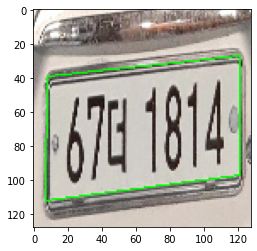

visualizing...


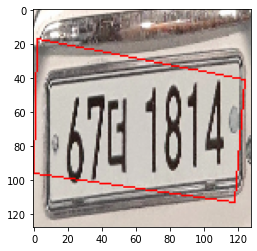

100%|██████████| 26/26 [01:41<00:00,  3.89s/it]

0.04759728854767044
::::Validation::::



100%|██████████| 7/7 [00:25<00:00,  3.63s/it]


smaller rmse, saving model weights...
best:  0.07288851 current rmse:  0.06035845
epoch4 end
::::Train::::



  0%|          | 0/26 [00:00<?, ?it/s]

visualizing...


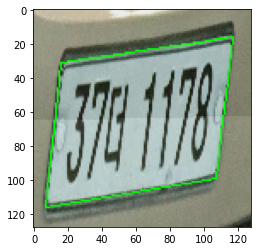

visualizing...


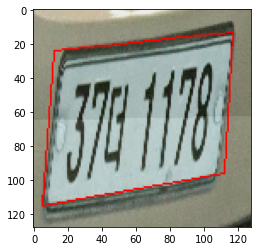

100%|██████████| 26/26 [01:42<00:00,  3.95s/it]

0.04222930341685584
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.43s/it]


smaller rmse, saving model weights...
best:  0.06035845 current rmse:  0.050501317
epoch5 end
::::Train::::



  0%|          | 0/26 [00:00<?, ?it/s]

visualizing...


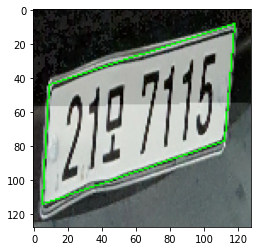

visualizing...


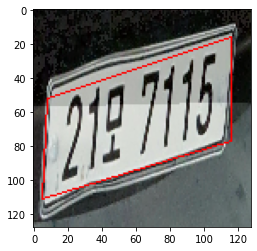

100%|██████████| 26/26 [01:44<00:00,  4.01s/it]

0.041105874967319884
::::Validation::::



100%|██████████| 7/7 [00:25<00:00,  3.58s/it]


smaller rmse, saving model weights...
best:  0.050501317 current rmse:  0.05019731
epoch6 end
::::Train::::



  0%|          | 0/26 [00:00<?, ?it/s]

visualizing...


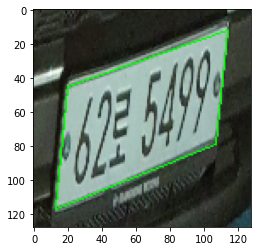

visualizing...


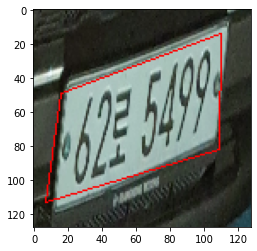

100%|██████████| 26/26 [01:42<00:00,  3.93s/it]

0.034076344834737454
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.50s/it]


smaller rmse, saving model weights...
best:  0.05019731 current rmse:  0.035441007
epoch7 end
::::Train::::


100%|██████████| 26/26 [01:43<00:00,  3.99s/it]

0.033807060010845144
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.56s/it]

epoch8 end
::::Train::::



100%|██████████| 26/26 [01:43<00:00,  3.99s/it]

0.032412477785476485
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.52s/it]


smaller rmse, saving model weights...
best:  0.035441007 current rmse:  0.028838212
epoch9 end
::::Train::::



  0%|          | 0/26 [00:00<?, ?it/s]

visualizing...


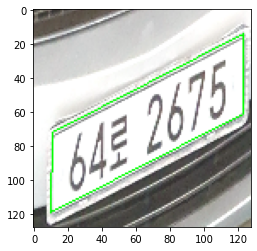

visualizing...


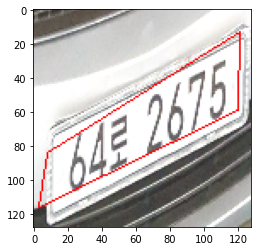

100%|██████████| 26/26 [01:42<00:00,  3.93s/it]

0.027606385811844367
::::Validation::::



  0%|          | 0/7 [00:00<?, ?it/s]

visualizing...


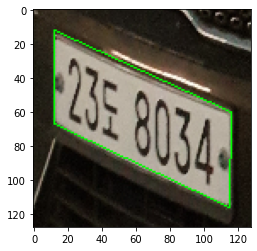

visualizing...


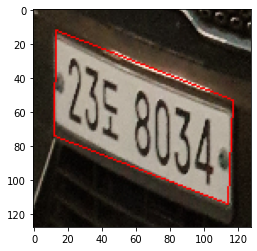

100%|██████████| 7/7 [00:24<00:00,  3.53s/it]

epoch10 end
::::Train::::



100%|██████████| 26/26 [01:44<00:00,  4.02s/it]

0.029794283681734257
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.38s/it]

epoch11 end
::::Train::::



100%|██████████| 26/26 [01:41<00:00,  3.91s/it]

0.027896278524708676
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.51s/it]

epoch12 end
::::Train::::



100%|██████████| 26/26 [01:41<00:00,  3.91s/it]

0.027595917039781537
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.43s/it]


smaller rmse, saving model weights...
best:  0.028838212 current rmse:  0.026564877
epoch13 end
::::Train::::


100%|██████████| 26/26 [01:44<00:00,  4.02s/it]

0.02703538481772675
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.51s/it]

epoch14 end
::::Train::::



100%|██████████| 26/26 [01:44<00:00,  4.02s/it]

0.024759702308143314
::::Validation::::



100%|██████████| 7/7 [00:25<00:00,  3.61s/it]


smaller rmse, saving model weights...
best:  0.026564877 current rmse:  0.022653965
epoch15 end
::::Train::::


100%|██████████| 26/26 [01:42<00:00,  3.96s/it]

0.023421465924482462
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.54s/it]

epoch16 end
::::Train::::



100%|██████████| 26/26 [01:41<00:00,  3.91s/it]

0.022639577674027248
::::Validation::::



100%|██████████| 7/7 [00:25<00:00,  3.57s/it]

epoch17 end
::::Train::::



100%|██████████| 26/26 [01:43<00:00,  3.98s/it]

0.023198441950325208
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.57s/it]


smaller rmse, saving model weights...
best:  0.022653965 current rmse:  0.02239403
epoch18 end
::::Train::::


100%|██████████| 26/26 [01:39<00:00,  3.82s/it]

0.023601230292008557
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.54s/it]

epoch19 end
::::Train::::



  0%|          | 0/26 [00:00<?, ?it/s]

visualizing...


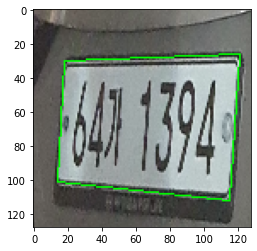

visualizing...


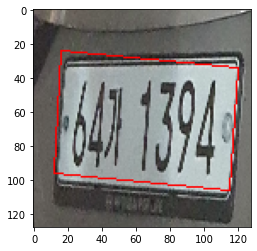

100%|██████████| 26/26 [01:43<00:00,  3.99s/it]

0.021731441379140275
::::Validation::::



  0%|          | 0/7 [00:00<?, ?it/s]

visualizing...


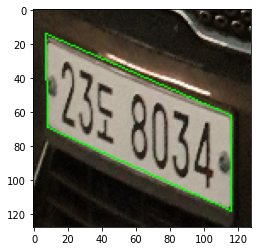

visualizing...


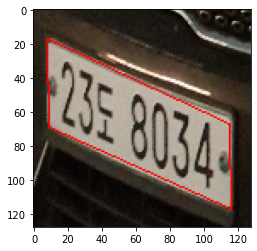

100%|██████████| 7/7 [00:24<00:00,  3.55s/it]


smaller rmse, saving model weights...
best:  0.02239403 current rmse:  0.020642955
epoch20 end
::::Train::::


100%|██████████| 26/26 [01:40<00:00,  3.87s/it]

0.022283383171766175
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.34s/it]

epoch21 end
::::Train::::



100%|██████████| 26/26 [01:41<00:00,  3.90s/it]

0.022416267349222384
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.44s/it]

epoch22 end
::::Train::::



100%|██████████| 26/26 [01:39<00:00,  3.81s/it]

0.02132969441672713
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.38s/it]

epoch23 end
::::Train::::



100%|██████████| 26/26 [01:39<00:00,  3.84s/it]

0.022028826521168426
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.45s/it]

epoch24 end
::::Train::::



100%|██████████| 26/26 [01:41<00:00,  3.89s/it]

0.021858032560403196
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.42s/it]

epoch25 end
::::Train::::



100%|██████████| 26/26 [01:40<00:00,  3.86s/it]

0.021479153949824314
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.40s/it]

epoch26 end
::::Train::::



100%|██████████| 26/26 [01:41<00:00,  3.90s/it]

0.01884105112916286
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.35s/it]


smaller rmse, saving model weights...
best:  0.020642955 current rmse:  0.01970849
epoch27 end
::::Train::::


100%|██████████| 26/26 [01:41<00:00,  3.91s/it]

0.019959686827541127
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.48s/it]

epoch28 end
::::Train::::



100%|██████████| 26/26 [01:43<00:00,  4.00s/it]

0.01944592747757559
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.51s/it]

epoch29 end
::::Train::::



  0%|          | 0/26 [00:00<?, ?it/s]

visualizing...


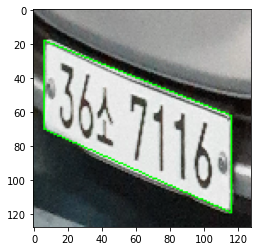

visualizing...


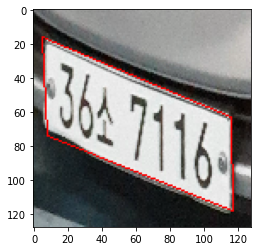

100%|██████████| 26/26 [01:43<00:00,  3.96s/it]

0.01811405823477729
::::Validation::::



  0%|          | 0/7 [00:00<?, ?it/s]

visualizing...


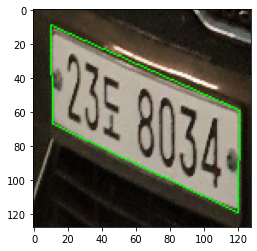

visualizing...


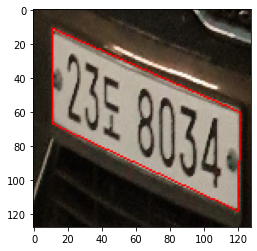

100%|██████████| 7/7 [00:24<00:00,  3.50s/it]


smaller rmse, saving model weights...
best:  0.01970849 current rmse:  0.018829474
epoch30 end
::::Train::::


100%|██████████| 26/26 [01:42<00:00,  3.95s/it]

0.019063756889478513
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.47s/it]

epoch31 end
::::Train::::



100%|██████████| 26/26 [01:42<00:00,  3.96s/it]

0.018917919801325973
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.48s/it]

epoch32 end
::::Train::::



100%|██████████| 26/26 [01:43<00:00,  3.99s/it]

0.0186653525924555
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.52s/it]

epoch33 end
::::Train::::



100%|██████████| 26/26 [01:43<00:00,  3.97s/it]

0.017288632745589685
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.53s/it]

epoch34 end
::::Train::::



100%|██████████| 26/26 [01:44<00:00,  4.00s/it]

0.018590475846685765
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.49s/it]

epoch35 end
::::Train::::



100%|██████████| 26/26 [01:41<00:00,  3.92s/it]

0.017350836838695254
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.47s/it]


smaller rmse, saving model weights...
best:  0.018829474 current rmse:  0.018596172
epoch36 end
::::Train::::


100%|██████████| 26/26 [01:44<00:00,  4.02s/it]

0.01632909239227072
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.53s/it]

epoch37 end
::::Train::::



100%|██████████| 26/26 [01:43<00:00,  3.99s/it]

0.017340414834405304
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.56s/it]

epoch38 end
::::Train::::



100%|██████████| 26/26 [01:43<00:00,  3.97s/it]

0.01759888315829662
::::Validation::::



100%|██████████| 7/7 [00:25<00:00,  3.59s/it]

epoch39 end
::::Train::::



  0%|          | 0/26 [00:00<?, ?it/s]

visualizing...


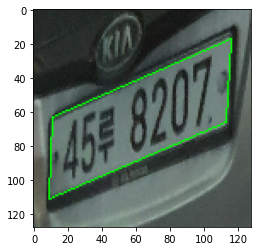

visualizing...


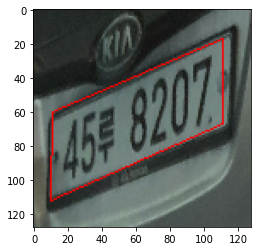

100%|██████████| 26/26 [01:44<00:00,  4.03s/it]

0.017425830350100813
::::Validation::::



  0%|          | 0/7 [00:00<?, ?it/s]

visualizing...


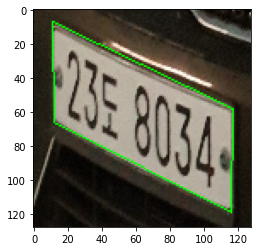

visualizing...


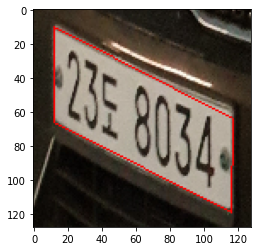

100%|██████████| 7/7 [00:24<00:00,  3.54s/it]

epoch40 end
::::Train::::



100%|██████████| 26/26 [01:44<00:00,  4.01s/it]

0.016758574520320337
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.51s/it]

epoch41 end
::::Train::::



100%|██████████| 26/26 [01:44<00:00,  4.01s/it]

0.016443468935628185
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.52s/it]


smaller rmse, saving model weights...
best:  0.018596172 current rmse:  0.017394098
epoch42 end
::::Train::::


100%|██████████| 26/26 [01:42<00:00,  3.94s/it]

0.01632535239561982
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.49s/it]

epoch43 end
::::Train::::



100%|██████████| 26/26 [01:43<00:00,  3.98s/it]

0.016420200232427785
::::Validation::::



100%|██████████| 7/7 [00:25<00:00,  3.57s/it]

epoch44 end
::::Train::::



100%|██████████| 26/26 [01:44<00:00,  4.01s/it]

0.01724498940443774
::::Validation::::



100%|██████████| 7/7 [00:25<00:00,  3.66s/it]

epoch45 end
::::Train::::



100%|██████████| 26/26 [01:42<00:00,  3.96s/it]

0.016467766569705184
::::Validation::::



100%|██████████| 7/7 [00:25<00:00,  3.66s/it]

epoch46 end
::::Train::::



100%|██████████| 26/26 [01:43<00:00,  3.96s/it]

0.01589733758878635
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.57s/it]

epoch47 end
::::Train::::



100%|██████████| 26/26 [01:43<00:00,  3.98s/it]

0.016870956928312596
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.52s/it]


smaller rmse, saving model weights...
best:  0.017394098 current rmse:  0.017111264
epoch48 end
::::Train::::


100%|██████████| 26/26 [01:42<00:00,  3.96s/it]

0.01625083761078958
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.51s/it]

epoch49 end
::::Train::::



  0%|          | 0/26 [00:00<?, ?it/s]

visualizing...


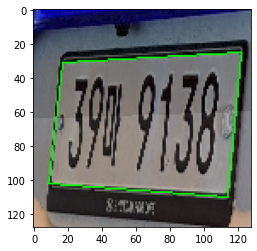

visualizing...


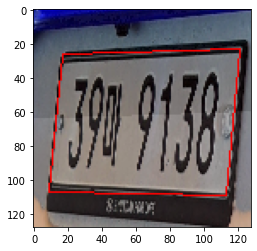

100%|██████████| 26/26 [01:44<00:00,  4.01s/it]


0.015085751823625251
::::Validation::::



  0%|          | 0/7 [00:00<?, ?it/s]

visualizing...


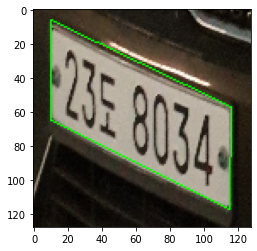

visualizing...


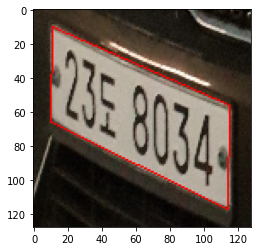

100%|██████████| 7/7 [00:24<00:00,  3.54s/it]

epoch50 end
::::Train::::



100%|██████████| 26/26 [01:45<00:00,  4.04s/it]

0.015164459422686414
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.48s/it]

epoch51 end
::::Train::::



100%|██████████| 26/26 [01:40<00:00,  3.86s/it]

0.015005650471565556
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.47s/it]

epoch52 end
::::Train::::



100%|██████████| 26/26 [01:40<00:00,  3.86s/it]

0.016117496709894697
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.43s/it]

epoch53 end
::::Train::::



100%|██████████| 26/26 [01:37<00:00,  3.75s/it]

0.015811487434813552
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.44s/it]

epoch54 end
::::Train::::



100%|██████████| 26/26 [01:41<00:00,  3.90s/it]


0.014722182829536794
::::Validation::::


100%|██████████| 7/7 [00:24<00:00,  3.47s/it]

epoch55 end
::::Train::::



100%|██████████| 26/26 [01:39<00:00,  3.83s/it]

0.01503260565596983
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.45s/it]

epoch56 end
::::Train::::



100%|██████████| 26/26 [01:40<00:00,  3.85s/it]

0.01545698235227245
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.39s/it]


smaller rmse, saving model weights...
best:  0.017111264 current rmse:  0.01691493
epoch57 end
::::Train::::


100%|██████████| 26/26 [01:42<00:00,  3.96s/it]

0.01489836086464949
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.51s/it]

epoch58 end
::::Train::::



100%|██████████| 26/26 [01:43<00:00,  3.99s/it]

0.013996766736611314
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.46s/it]

epoch59 end
::::Train::::



100%|██████████| 26/26 [01:43<00:00,  3.97s/it]

0.01510392263394977
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.49s/it]

epoch60 end
::::Train::::



100%|██████████| 26/26 [01:43<00:00,  3.98s/it]

0.014820086041220466
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.48s/it]

epoch61 end
::::Train::::



100%|██████████| 26/26 [01:40<00:00,  3.88s/it]

0.01567412678961178
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.51s/it]

epoch62 end
::::Train::::



100%|██████████| 26/26 [01:42<00:00,  3.93s/it]

0.013978364650125898
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.51s/it]


smaller rmse, saving model weights...
best:  0.01691493 current rmse:  0.016397387
epoch63 end
::::Train::::


100%|██████████| 26/26 [01:44<00:00,  4.02s/it]

0.01442087430518337
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.56s/it]


smaller rmse, saving model weights...
best:  0.016397387 current rmse:  0.0153318485
epoch64 end
::::Train::::


100%|██████████| 26/26 [01:45<00:00,  4.04s/it]

0.014806129034916196
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.54s/it]

epoch65 end
::::Train::::



100%|██████████| 26/26 [01:42<00:00,  3.93s/it]

0.014734824247863314
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.53s/it]

epoch66 end
::::Train::::



100%|██████████| 26/26 [01:43<00:00,  4.00s/it]

0.013803370374422919
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.56s/it]

epoch67 end
::::Train::::



100%|██████████| 26/26 [01:43<00:00,  4.00s/it]

0.01387592937273261
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.49s/it]


smaller rmse, saving model weights...
best:  0.0153318485 current rmse:  0.014247619
epoch68 end
::::Train::::


100%|██████████| 26/26 [01:39<00:00,  3.85s/it]

0.013683775108911393
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.45s/it]

epoch69 end
::::Train::::



100%|██████████| 26/26 [01:41<00:00,  3.92s/it]

0.013560646471627262
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.38s/it]

epoch70 end
::::Train::::



100%|██████████| 26/26 [01:40<00:00,  3.86s/it]

0.013682565295823852
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.41s/it]

epoch71 end
::::Train::::



100%|██████████| 26/26 [01:40<00:00,  3.87s/it]

0.014031221919809824
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.41s/it]

epoch72 end
::::Train::::



100%|██████████| 26/26 [01:38<00:00,  3.80s/it]

0.014403762328310298
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.42s/it]

epoch73 end
::::Train::::



100%|██████████| 26/26 [01:41<00:00,  3.90s/it]

0.01400475550545465
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.42s/it]

epoch74 end
::::Train::::



100%|██████████| 26/26 [01:41<00:00,  3.90s/it]

0.013836946507021558
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.48s/it]

epoch75 end
::::Train::::



100%|██████████| 26/26 [01:40<00:00,  3.86s/it]

0.013627434547546259
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.40s/it]

epoch76 end
::::Train::::



100%|██████████| 26/26 [01:40<00:00,  3.87s/it]

0.013800387095306808
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.45s/it]

epoch77 end
::::Train::::



100%|██████████| 26/26 [01:40<00:00,  3.87s/it]

0.013658144506155897
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.44s/it]

epoch78 end
::::Train::::



100%|██████████| 26/26 [01:40<00:00,  3.87s/it]

0.012866349150327003
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.40s/it]

epoch79 end
::::Train::::



  0%|          | 0/26 [00:00<?, ?it/s]

visualizing...


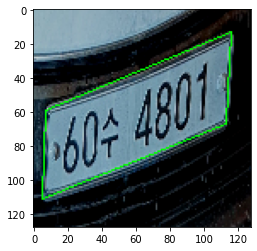

visualizing...


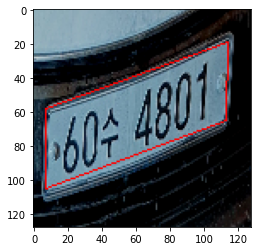

100%|██████████| 26/26 [01:40<00:00,  3.85s/it]

0.012879356802854151
::::Validation::::



  0%|          | 0/7 [00:00<?, ?it/s]

visualizing...


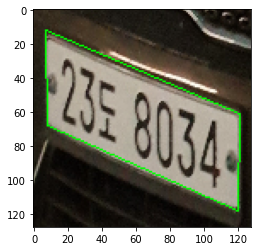

visualizing...


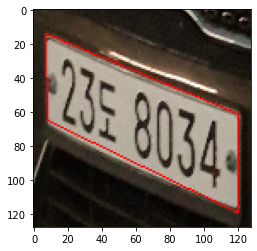

100%|██████████| 7/7 [00:24<00:00,  3.44s/it]

epoch80 end
::::Train::::



100%|██████████| 26/26 [01:45<00:00,  4.05s/it]

0.013542652610313455
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.42s/it]

epoch81 end
::::Train::::



100%|██████████| 26/26 [01:40<00:00,  3.85s/it]

0.013831383480323017
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.42s/it]

epoch82 end
::::Train::::



100%|██████████| 26/26 [01:39<00:00,  3.83s/it]

0.0139331663352087
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.45s/it]

epoch83 end
::::Train::::



100%|██████████| 26/26 [01:39<00:00,  3.83s/it]

0.013446799085820122
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.44s/it]

epoch84 end
::::Train::::



100%|██████████| 26/26 [01:38<00:00,  3.79s/it]

0.013862634179059884
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.33s/it]

epoch85 end
::::Train::::



100%|██████████| 26/26 [01:41<00:00,  3.89s/it]

0.013991600058585496
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.42s/it]

epoch86 end
::::Train::::



100%|██████████| 26/26 [01:40<00:00,  3.87s/it]

0.013717548810059507
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.40s/it]

epoch87 end
::::Train::::



100%|██████████| 26/26 [01:40<00:00,  3.87s/it]

0.013863054068833133
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.37s/it]

epoch88 end
::::Train::::



100%|██████████| 26/26 [01:39<00:00,  3.83s/it]

0.01282834801936824
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.45s/it]

epoch89 end
::::Train::::



100%|██████████| 26/26 [01:40<00:00,  3.88s/it]

0.013997262497560694
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.42s/it]

epoch90 end
::::Train::::



100%|██████████| 26/26 [01:40<00:00,  3.86s/it]

0.013308946047809874
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.41s/it]

epoch91 end
::::Train::::



100%|██████████| 26/26 [01:40<00:00,  3.88s/it]

0.013029626251087277
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.42s/it]

epoch92 end
::::Train::::



100%|██████████| 26/26 [01:40<00:00,  3.88s/it]

0.013043471524884942
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.40s/it]

epoch93 end
::::Train::::



100%|██████████| 26/26 [01:41<00:00,  3.89s/it]

0.013257717606056174
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.41s/it]

epoch94 end
::::Train::::



100%|██████████| 26/26 [01:38<00:00,  3.79s/it]

0.013532807902982658
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.39s/it]

epoch95 end
::::Train::::



100%|██████████| 26/26 [01:41<00:00,  3.91s/it]

0.013262967932228831
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.36s/it]

epoch96 end
::::Train::::



100%|██████████| 26/26 [01:40<00:00,  3.88s/it]

0.01281030995070661
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.44s/it]

epoch97 end
::::Train::::



100%|██████████| 26/26 [01:39<00:00,  3.84s/it]

0.012929045722253096
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.41s/it]

epoch98 end
::::Train::::



100%|██████████| 26/26 [01:40<00:00,  3.85s/it]

0.01257753951606036
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.47s/it]

epoch99 end
::::Train::::



  0%|          | 0/26 [00:00<?, ?it/s]

visualizing...


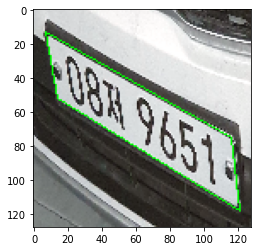

visualizing...


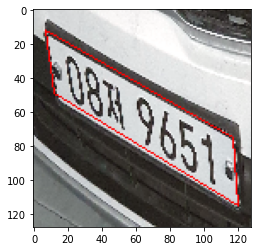

100%|██████████| 26/26 [01:38<00:00,  3.79s/it]

0.013008238971005521
::::Validation::::



  0%|          | 0/7 [00:00<?, ?it/s]

visualizing...


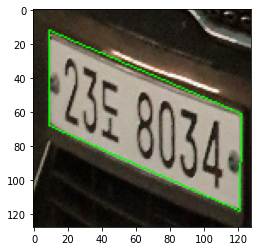

visualizing...


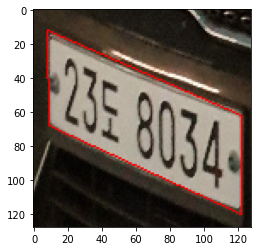

100%|██████████| 7/7 [00:23<00:00,  3.40s/it]

epoch100 end
::::Train::::



100%|██████████| 26/26 [01:43<00:00,  3.96s/it]

0.012874642763548853
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.37s/it]

epoch101 end
::::Train::::



100%|██████████| 26/26 [01:42<00:00,  3.92s/it]

0.012665234529484485
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.45s/it]

epoch102 end
::::Train::::



100%|██████████| 26/26 [01:42<00:00,  3.93s/it]

0.012772068128399892
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.49s/it]

epoch103 end
::::Train::::



100%|██████████| 26/26 [01:39<00:00,  3.81s/it]

0.013169294971665111
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.39s/it]

epoch104 end
::::Train::::



100%|██████████| 26/26 [01:42<00:00,  3.94s/it]

0.013000052685447789
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.48s/it]

epoch105 end
::::Train::::



100%|██████████| 26/26 [01:40<00:00,  3.87s/it]

0.012531126888656836
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.39s/it]

epoch106 end
::::Train::::



100%|██████████| 26/26 [01:40<00:00,  3.88s/it]

0.012490328996576119
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.41s/it]

epoch107 end
::::Train::::



100%|██████████| 26/26 [01:41<00:00,  3.90s/it]

0.01209256869458824
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.44s/it]

epoch108 end
::::Train::::



100%|██████████| 26/26 [01:39<00:00,  3.81s/it]

0.012609593900040203
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.44s/it]

epoch109 end
::::Train::::



100%|██████████| 26/26 [01:41<00:00,  3.89s/it]


0.012159042240943566
::::Validation::::


100%|██████████| 7/7 [00:24<00:00,  3.44s/it]

epoch110 end
::::Train::::



100%|██████████| 26/26 [01:40<00:00,  3.86s/it]

0.01220535938072642
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.36s/it]

epoch111 end
::::Train::::



100%|██████████| 26/26 [01:41<00:00,  3.90s/it]

0.012549674108806735
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.39s/it]

epoch112 end
::::Train::::



100%|██████████| 26/26 [01:41<00:00,  3.89s/it]

0.01256504743744474
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.33s/it]

epoch113 end
::::Train::::



100%|██████████| 26/26 [01:39<00:00,  3.85s/it]

0.012862870058426434
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.38s/it]

epoch114 end
::::Train::::



100%|██████████| 26/26 [01:42<00:00,  3.94s/it]

0.012516060157676173
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.37s/it]

epoch115 end
::::Train::::



100%|██████████| 26/26 [01:41<00:00,  3.90s/it]

0.012005760828289417
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.41s/it]

epoch116 end
::::Train::::



100%|██████████| 26/26 [01:41<00:00,  3.91s/it]

0.011768390095881001
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.40s/it]

epoch117 end
::::Train::::



100%|██████████| 26/26 [01:40<00:00,  3.86s/it]


0.012067734650037158
::::Validation::::


100%|██████████| 7/7 [00:24<00:00,  3.53s/it]

epoch118 end
::::Train::::



100%|██████████| 26/26 [01:41<00:00,  3.89s/it]

0.012723926547060319
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.39s/it]

epoch119 end
::::Train::::



100%|██████████| 26/26 [01:39<00:00,  3.83s/it]

0.012379393484500388
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.43s/it]

epoch120 end
::::Train::::



100%|██████████| 26/26 [01:43<00:00,  3.97s/it]

0.012221079063957802
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.37s/it]

epoch121 end
::::Train::::



100%|██████████| 26/26 [01:40<00:00,  3.85s/it]

0.012400683615960476
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.42s/it]

epoch122 end
::::Train::::



100%|██████████| 26/26 [01:38<00:00,  3.81s/it]

0.011748395938802203
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.36s/it]

epoch123 end
::::Train::::



100%|██████████| 26/26 [01:39<00:00,  3.84s/it]

0.012171522122935964
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.44s/it]

epoch124 end
::::Train::::



100%|██████████| 26/26 [01:41<00:00,  3.90s/it]

0.011834397370890011
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.40s/it]

epoch125 end
::::Train::::



100%|██████████| 26/26 [01:37<00:00,  3.77s/it]

0.012171243009832473
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.43s/it]

epoch126 end
::::Train::::



100%|██████████| 26/26 [01:41<00:00,  3.89s/it]

0.011574387731491973
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.44s/it]

epoch127 end
::::Train::::



100%|██████████| 26/26 [01:41<00:00,  3.92s/it]

0.011608309469068998
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.35s/it]

epoch128 end
::::Train::::



100%|██████████| 26/26 [01:40<00:00,  3.85s/it]

0.011400546100480476
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.47s/it]

epoch129 end
::::Train::::



  0%|          | 0/26 [00:00<?, ?it/s]

visualizing...


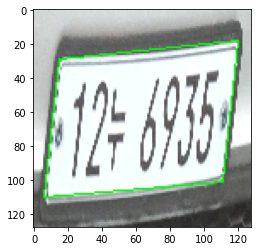

visualizing...


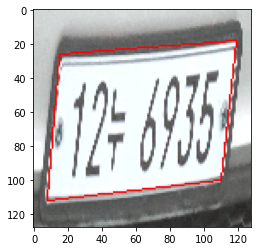

100%|██████████| 26/26 [01:40<00:00,  3.86s/it]

0.011998449448803697
::::Validation::::



  0%|          | 0/7 [00:00<?, ?it/s]

visualizing...


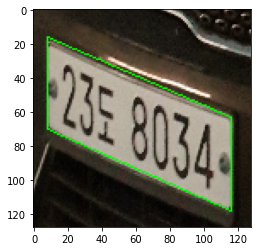

visualizing...


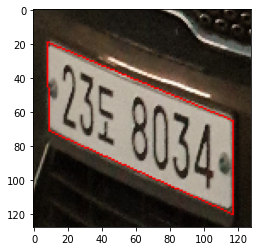

100%|██████████| 7/7 [00:24<00:00,  3.47s/it]

epoch130 end
::::Train::::



100%|██████████| 26/26 [01:46<00:00,  4.09s/it]

0.011761415618776546
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.43s/it]

epoch131 end
::::Train::::



100%|██████████| 26/26 [01:44<00:00,  4.03s/it]

0.011428422611833348
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.54s/it]

epoch132 end
::::Train::::



100%|██████████| 26/26 [01:43<00:00,  3.97s/it]

0.011629449997085862
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.53s/it]

epoch133 end
::::Train::::



100%|██████████| 26/26 [01:41<00:00,  3.91s/it]

0.012070685056599273
::::Validation::::



100%|██████████| 7/7 [00:25<00:00,  3.57s/it]

epoch134 end
::::Train::::



100%|██████████| 26/26 [01:44<00:00,  4.01s/it]

0.011910915261402226
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.51s/it]

epoch135 end
::::Train::::



100%|██████████| 26/26 [01:44<00:00,  4.02s/it]

0.011569082938613149
::::Validation::::



100%|██████████| 7/7 [00:25<00:00,  3.58s/it]

epoch136 end
::::Train::::



100%|██████████| 26/26 [01:42<00:00,  3.94s/it]

0.011075546831143195
::::Validation::::



100%|██████████| 7/7 [00:25<00:00,  3.58s/it]

epoch137 end
::::Train::::



100%|██████████| 26/26 [01:42<00:00,  3.96s/it]


0.01155857002470836
::::Validation::::


100%|██████████| 7/7 [00:24<00:00,  3.50s/it]

epoch138 end
::::Train::::



100%|██████████| 26/26 [01:44<00:00,  4.01s/it]

0.01154928973360437
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.51s/it]

epoch139 end
::::Train::::



100%|██████████| 26/26 [01:43<00:00,  3.99s/it]

0.01191183365140942
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.51s/it]

epoch140 end
::::Train::::



100%|██████████| 26/26 [01:44<00:00,  4.01s/it]

0.011774153411616244
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.55s/it]

epoch141 end
::::Train::::



100%|██████████| 26/26 [01:42<00:00,  3.94s/it]

0.012316580404974634
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.52s/it]

epoch142 end
::::Train::::



100%|██████████| 26/26 [01:41<00:00,  3.91s/it]

0.011251595222735805
::::Validation::::



100%|██████████| 7/7 [00:25<00:00,  3.59s/it]

epoch143 end
::::Train::::



100%|██████████| 26/26 [01:42<00:00,  3.93s/it]

0.011145575025007813
::::Validation::::



100%|██████████| 7/7 [00:25<00:00,  3.60s/it]

epoch144 end
::::Train::::



100%|██████████| 26/26 [01:42<00:00,  3.93s/it]

0.01114434919146314
::::Validation::::



100%|██████████| 7/7 [00:25<00:00,  3.61s/it]

epoch145 end
::::Train::::



100%|██████████| 26/26 [01:41<00:00,  3.92s/it]

0.011511847516379407
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.53s/it]

epoch146 end
::::Train::::



100%|██████████| 26/26 [01:43<00:00,  3.98s/it]

0.01166636274176271
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.53s/it]

epoch147 end
::::Train::::



100%|██████████| 26/26 [01:42<00:00,  3.94s/it]

0.010894791795003488
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.53s/it]

epoch148 end
::::Train::::



100%|██████████| 26/26 [01:43<00:00,  3.99s/it]

0.012153011443099115
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.55s/it]

epoch149 end
::::Train::::



  0%|          | 0/26 [00:00<?, ?it/s]

visualizing...


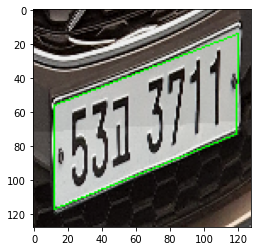

visualizing...


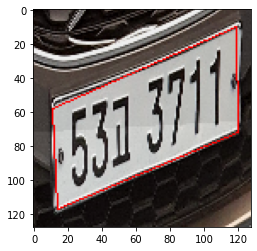

100%|██████████| 26/26 [01:43<00:00,  3.98s/it]

0.011794104261340898
::::Validation::::



  0%|          | 0/7 [00:00<?, ?it/s]

visualizing...


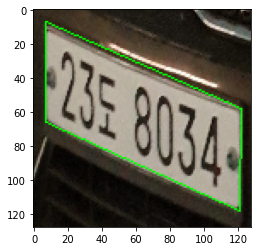

visualizing...


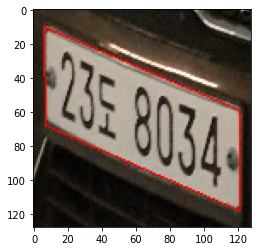

100%|██████████| 7/7 [00:24<00:00,  3.56s/it]

epoch150 end
::::Train::::



100%|██████████| 26/26 [01:43<00:00,  3.96s/it]

0.011027018635303056
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.55s/it]

epoch151 end
::::Train::::



100%|██████████| 26/26 [01:41<00:00,  3.92s/it]

0.011546663956471722
::::Validation::::



100%|██████████| 7/7 [00:25<00:00,  3.60s/it]

epoch152 end
::::Train::::



100%|██████████| 26/26 [01:44<00:00,  4.01s/it]

0.011208987638172024
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.54s/it]

epoch153 end
::::Train::::



100%|██████████| 26/26 [01:42<00:00,  3.96s/it]

0.012850705890799516
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.54s/it]

epoch154 end
::::Train::::



100%|██████████| 26/26 [01:43<00:00,  3.98s/it]

0.01234720979022597
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.49s/it]

epoch155 end
::::Train::::



100%|██████████| 26/26 [01:41<00:00,  3.89s/it]

0.012565892846508674
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.50s/it]

epoch156 end
::::Train::::



100%|██████████| 26/26 [01:43<00:00,  3.99s/it]

0.011987360894953438
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.55s/it]

epoch157 end
::::Train::::



100%|██████████| 26/26 [01:39<00:00,  3.84s/it]

0.011683461781511431
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.48s/it]

epoch158 end
::::Train::::



100%|██████████| 26/26 [01:44<00:00,  4.03s/it]

0.012085297973171469
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.53s/it]


smaller rmse, saving model weights...
best:  0.014247619 current rmse:  0.014030497
epoch159 end
::::Train::::


100%|██████████| 26/26 [01:45<00:00,  4.05s/it]

0.01116520703203452
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.50s/it]

epoch160 end
::::Train::::



100%|██████████| 26/26 [01:41<00:00,  3.92s/it]

0.012023168888273407
::::Validation::::



100%|██████████| 7/7 [00:25<00:00,  3.69s/it]

epoch161 end
::::Train::::



100%|██████████| 26/26 [01:44<00:00,  4.02s/it]

0.011783719695648833
::::Validation::::



100%|██████████| 7/7 [00:25<00:00,  3.64s/it]

epoch162 end
::::Train::::



100%|██████████| 26/26 [01:44<00:00,  4.01s/it]

0.01166863475245529
::::Validation::::



100%|██████████| 7/7 [00:25<00:00,  3.59s/it]

epoch163 end
::::Train::::



100%|██████████| 26/26 [01:41<00:00,  3.90s/it]

0.011589924524615117
::::Validation::::



100%|██████████| 7/7 [00:25<00:00,  3.58s/it]

epoch164 end
::::Train::::



100%|██████████| 26/26 [01:44<00:00,  4.04s/it]

0.011771490446516862
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.55s/it]

epoch165 end
::::Train::::



100%|██████████| 26/26 [01:43<00:00,  3.98s/it]

0.01143571849320004
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.51s/it]

epoch166 end
::::Train::::



100%|██████████| 26/26 [01:41<00:00,  3.92s/it]

0.012002747108311099
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.51s/it]

epoch167 end
::::Train::::



100%|██████████| 26/26 [01:42<00:00,  3.93s/it]

0.011087906512144145
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.54s/it]

epoch168 end
::::Train::::



100%|██████████| 26/26 [01:44<00:00,  4.01s/it]

0.011718491460865973
::::Validation::::



100%|██████████| 7/7 [00:25<00:00,  3.58s/it]

epoch169 end
::::Train::::



  0%|          | 0/26 [00:00<?, ?it/s]

visualizing...


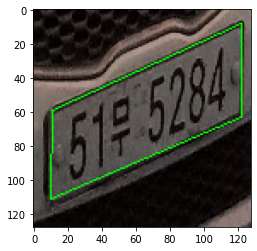

visualizing...


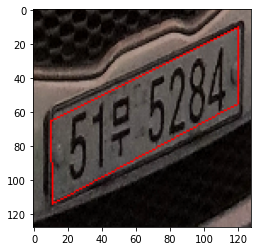

100%|██████████| 26/26 [01:42<00:00,  3.95s/it]

0.011881115523933089
::::Validation::::



  0%|          | 0/7 [00:00<?, ?it/s]

visualizing...


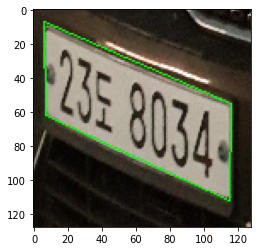

visualizing...


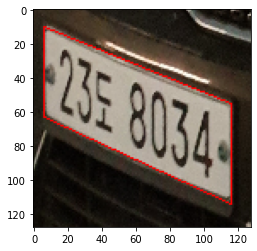

100%|██████████| 7/7 [00:24<00:00,  3.52s/it]

epoch170 end
::::Train::::



100%|██████████| 26/26 [01:44<00:00,  4.02s/it]

0.011559399851350063
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.31s/it]

epoch171 end
::::Train::::



100%|██████████| 26/26 [01:44<00:00,  4.02s/it]

0.011251872598509722
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.52s/it]

epoch172 end
::::Train::::



100%|██████████| 26/26 [01:43<00:00,  3.97s/it]

0.011094691518363784
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.36s/it]

epoch173 end
::::Train::::



100%|██████████| 26/26 [01:42<00:00,  3.95s/it]

0.010968098511480775
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.32s/it]

epoch174 end
::::Train::::



100%|██████████| 26/26 [01:37<00:00,  3.76s/it]

0.011443122917791936
::::Validation::::



100%|██████████| 7/7 [00:22<00:00,  3.20s/it]

epoch175 end
::::Train::::



100%|██████████| 26/26 [01:38<00:00,  3.79s/it]

0.011231485232482992
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.37s/it]

epoch176 end
::::Train::::



100%|██████████| 26/26 [01:38<00:00,  3.77s/it]

0.011551318691889627
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.31s/it]

epoch177 end
::::Train::::



100%|██████████| 26/26 [01:43<00:00,  3.96s/it]

0.011126048361102193
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.29s/it]

epoch178 end
::::Train::::



100%|██████████| 26/26 [01:44<00:00,  4.03s/it]

0.011060407756050246
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.54s/it]

epoch179 end
::::Train::::



100%|██████████| 26/26 [01:44<00:00,  4.02s/it]

0.010612320503510466
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.32s/it]

epoch180 end
::::Train::::



100%|██████████| 26/26 [01:43<00:00,  3.99s/it]

0.010957072745860535
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.48s/it]

epoch181 end
::::Train::::



100%|██████████| 26/26 [01:45<00:00,  4.04s/it]

0.01093704781013709
::::Validation::::



100%|██████████| 7/7 [00:25<00:00,  3.62s/it]

epoch182 end
::::Train::::



100%|██████████| 26/26 [01:46<00:00,  4.09s/it]

0.010569420298532972
::::Validation::::



100%|██████████| 7/7 [00:22<00:00,  3.27s/it]

epoch183 end
::::Train::::



100%|██████████| 26/26 [01:36<00:00,  3.72s/it]

0.010853271184642927
::::Validation::::



100%|██████████| 7/7 [00:22<00:00,  3.27s/it]

epoch184 end
::::Train::::



100%|██████████| 26/26 [01:35<00:00,  3.67s/it]

0.01047925970799059
::::Validation::::



100%|██████████| 7/7 [00:22<00:00,  3.18s/it]


smaller rmse, saving model weights...
best:  0.014030497 current rmse:  0.01396591
epoch185 end
::::Train::::


100%|██████████| 26/26 [01:33<00:00,  3.60s/it]


0.01065279953580475
::::Validation::::


100%|██████████| 7/7 [00:22<00:00,  3.17s/it]

epoch186 end
::::Train::::



100%|██████████| 26/26 [01:33<00:00,  3.59s/it]

0.01042288644153864
::::Validation::::



100%|██████████| 7/7 [00:22<00:00,  3.18s/it]

epoch187 end
::::Train::::



100%|██████████| 26/26 [01:35<00:00,  3.66s/it]

0.010999551271900124
::::Validation::::



100%|██████████| 7/7 [00:22<00:00,  3.26s/it]

epoch188 end
::::Train::::



100%|██████████| 26/26 [01:34<00:00,  3.63s/it]

0.011336352339509977
::::Validation::::



100%|██████████| 7/7 [00:22<00:00,  3.21s/it]

epoch189 end
::::Train::::



  0%|          | 0/26 [00:00<?, ?it/s]

visualizing...


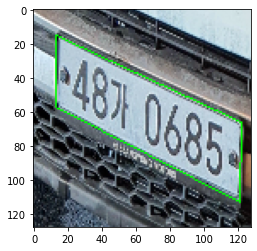

visualizing...


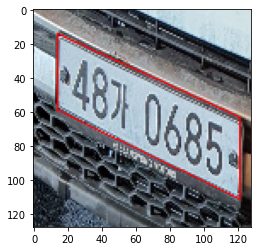

100%|██████████| 26/26 [01:36<00:00,  3.73s/it]

0.010826120063639744
::::Validation::::



  0%|          | 0/7 [00:00<?, ?it/s]

visualizing...


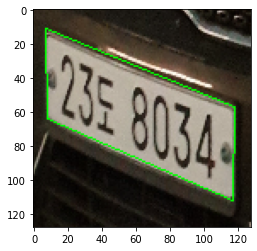

visualizing...


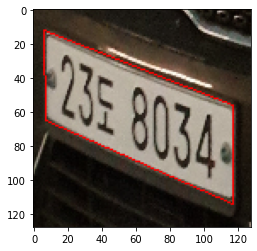

100%|██████████| 7/7 [00:22<00:00,  3.16s/it]


smaller rmse, saving model weights...
best:  0.01396591 current rmse:  0.013635482
epoch190 end
::::Train::::


100%|██████████| 26/26 [01:34<00:00,  3.64s/it]

0.010637271850275885
::::Validation::::



100%|██████████| 7/7 [00:22<00:00,  3.17s/it]

epoch191 end
::::Train::::



100%|██████████| 26/26 [01:34<00:00,  3.65s/it]

0.010573241341323663
::::Validation::::



100%|██████████| 7/7 [00:22<00:00,  3.22s/it]

epoch192 end
::::Train::::



100%|██████████| 26/26 [01:36<00:00,  3.70s/it]


0.011043978219891724
::::Validation::::


100%|██████████| 7/7 [00:22<00:00,  3.15s/it]

epoch193 end
::::Train::::



100%|██████████| 26/26 [01:38<00:00,  3.77s/it]

0.010900799473833054
::::Validation::::



100%|██████████| 7/7 [00:22<00:00,  3.22s/it]

epoch194 end
::::Train::::



100%|██████████| 26/26 [01:35<00:00,  3.68s/it]

0.011035863371047587
::::Validation::::



100%|██████████| 7/7 [00:25<00:00,  3.62s/it]

epoch195 end
::::Train::::



100%|██████████| 26/26 [01:44<00:00,  4.03s/it]

0.010808314155183437
::::Validation::::



100%|██████████| 7/7 [00:25<00:00,  3.67s/it]

epoch196 end
::::Train::::



100%|██████████| 26/26 [01:44<00:00,  4.04s/it]

0.010669465419987291
::::Validation::::



100%|██████████| 7/7 [00:25<00:00,  3.57s/it]

epoch197 end
::::Train::::



100%|██████████| 26/26 [01:43<00:00,  4.00s/it]


0.010752163972101809
::::Validation::::


100%|██████████| 7/7 [00:24<00:00,  3.54s/it]

epoch198 end
::::Train::::



100%|██████████| 26/26 [01:46<00:00,  4.10s/it]

0.010739425459267166
::::Validation::::



100%|██████████| 7/7 [00:25<00:00,  3.58s/it]

epoch199 end
::::Train::::



100%|██████████| 26/26 [01:44<00:00,  4.02s/it]

0.010931730258993418
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.57s/it]

epoch200 end
::::Train::::



100%|██████████| 26/26 [01:44<00:00,  4.00s/it]

0.010579759113786781
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.35s/it]

epoch201 end
::::Train::::



100%|██████████| 26/26 [01:43<00:00,  3.98s/it]

0.01064912835449345
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.54s/it]

epoch202 end
::::Train::::



100%|██████████| 26/26 [01:43<00:00,  3.98s/it]

0.010644164832952555
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.37s/it]

epoch203 end
::::Train::::



100%|██████████| 26/26 [01:43<00:00,  4.00s/it]

0.010741251463850887
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.38s/it]

epoch204 end
::::Train::::



100%|██████████| 26/26 [01:45<00:00,  4.07s/it]

0.010646514984172418
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.29s/it]

epoch205 end
::::Train::::



100%|██████████| 26/26 [01:43<00:00,  3.96s/it]

0.010626900901829977
::::Validation::::



100%|██████████| 7/7 [00:25<00:00,  3.60s/it]

epoch206 end
::::Train::::



100%|██████████| 26/26 [01:45<00:00,  4.06s/it]

0.010519873263137785
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.55s/it]


smaller rmse, saving model weights...
best:  0.013635482 current rmse:  0.01363299
epoch207 end
::::Train::::


100%|██████████| 26/26 [01:42<00:00,  3.93s/it]

0.010840019012946601
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.51s/it]

epoch208 end
::::Train::::



100%|██████████| 26/26 [01:42<00:00,  3.95s/it]

0.010598643399797813
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.55s/it]

epoch209 end
::::Train::::



  0%|          | 0/26 [00:00<?, ?it/s]

visualizing...


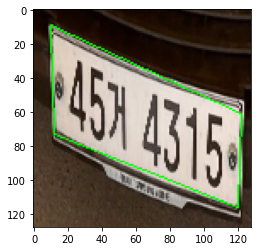

visualizing...


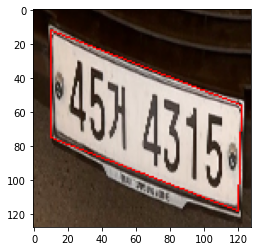

100%|██████████| 26/26 [01:44<00:00,  4.01s/it]

0.010651777210767845
::::Validation::::



  0%|          | 0/7 [00:00<?, ?it/s]

visualizing...


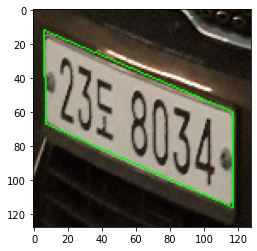

visualizing...


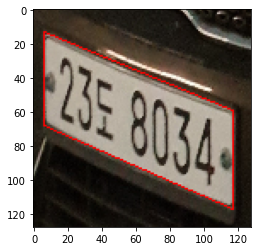

100%|██████████| 7/7 [00:22<00:00,  3.24s/it]

epoch210 end
::::Train::::



100%|██████████| 26/26 [01:43<00:00,  3.99s/it]

0.010031122655040992
::::Validation::::



100%|██████████| 7/7 [00:25<00:00,  3.60s/it]


smaller rmse, saving model weights...
best:  0.01363299 current rmse:  0.01332258
epoch211 end
::::Train::::


100%|██████████| 26/26 [01:46<00:00,  4.08s/it]

0.01039090051460977
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.29s/it]

epoch212 end
::::Train::::



100%|██████████| 26/26 [01:45<00:00,  4.04s/it]

0.01044607165209744
::::Validation::::



100%|██████████| 7/7 [00:22<00:00,  3.27s/it]

epoch213 end
::::Train::::



100%|██████████| 26/26 [01:38<00:00,  3.79s/it]

0.010477997949888036
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.41s/it]

epoch214 end
::::Train::::



100%|██████████| 26/26 [01:44<00:00,  4.04s/it]

0.009897477984633467
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.34s/it]

epoch215 end
::::Train::::



100%|██████████| 26/26 [01:44<00:00,  4.02s/it]


0.01053574731522197
::::Validation::::


100%|██████████| 7/7 [00:24<00:00,  3.55s/it]

epoch216 end
::::Train::::



100%|██████████| 26/26 [01:39<00:00,  3.83s/it]

0.010503366128726654
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.54s/it]

epoch217 end
::::Train::::



100%|██████████| 26/26 [01:44<00:00,  4.00s/it]

0.010473964232324825
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.40s/it]

epoch218 end
::::Train::::



100%|██████████| 26/26 [01:46<00:00,  4.08s/it]

0.010118099873948171
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.34s/it]

epoch219 end
::::Train::::



100%|██████████| 26/26 [01:45<00:00,  4.06s/it]

0.010420687914190855
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.32s/it]

epoch220 end
::::Train::::



100%|██████████| 26/26 [01:45<00:00,  4.04s/it]

0.010865959927257413
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.31s/it]

epoch221 end
::::Train::::



100%|██████████| 26/26 [01:44<00:00,  4.03s/it]

0.010325952391467693
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.57s/it]

epoch222 end
::::Train::::



100%|██████████| 26/26 [01:45<00:00,  4.04s/it]

0.01042880711775125
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.55s/it]

epoch223 end
::::Train::::



100%|██████████| 26/26 [01:43<00:00,  3.98s/it]

0.010087608535765508
::::Validation::::



100%|██████████| 7/7 [00:25<00:00,  3.58s/it]

epoch224 end
::::Train::::



100%|██████████| 26/26 [01:43<00:00,  3.98s/it]

0.010076107067093025
::::Validation::::



100%|██████████| 7/7 [00:24<00:00,  3.57s/it]

epoch225 end
::::Train::::



100%|██████████| 26/26 [01:43<00:00,  3.99s/it]

0.011110817356781311
::::Validation::::



100%|██████████| 7/7 [00:25<00:00,  3.58s/it]


smaller rmse, saving model weights...
best:  0.01332258 current rmse:  0.013298273
epoch226 end
::::Train::::


100%|██████████| 26/26 [01:43<00:00,  3.98s/it]

0.010475046523712827
::::Validation::::



100%|██████████| 7/7 [00:25<00:00,  3.61s/it]

epoch227 end
::::Train::::



100%|██████████| 26/26 [01:46<00:00,  4.09s/it]

0.010404826521827905
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.30s/it]

epoch228 end
::::Train::::



100%|██████████| 26/26 [01:43<00:00,  4.00s/it]

0.010166515932854163
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.33s/it]

epoch229 end
::::Train::::



  0%|          | 0/26 [00:00<?, ?it/s]

visualizing...


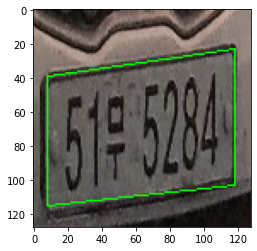

visualizing...


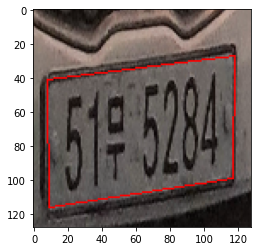

100%|██████████| 26/26 [01:45<00:00,  4.05s/it]

0.010246998670337215
::::Validation::::



  0%|          | 0/7 [00:00<?, ?it/s]

visualizing...


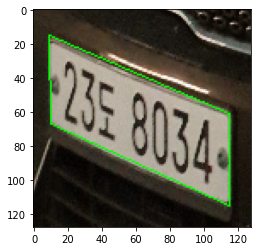

visualizing...


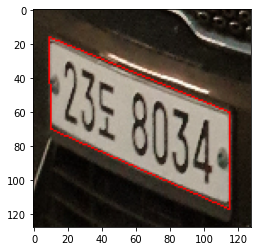

100%|██████████| 7/7 [00:23<00:00,  3.31s/it]

epoch230 end
::::Train::::



100%|██████████| 26/26 [01:39<00:00,  3.81s/it]

0.01010553456831507
::::Validation::::



100%|██████████| 7/7 [00:22<00:00,  3.15s/it]

epoch231 end
::::Train::::



100%|██████████| 26/26 [01:35<00:00,  3.66s/it]

0.010299814699234766
::::Validation::::



100%|██████████| 7/7 [00:22<00:00,  3.24s/it]

epoch232 end
::::Train::::



100%|██████████| 26/26 [01:33<00:00,  3.61s/it]

0.010305648832510735
::::Validation::::



100%|██████████| 7/7 [00:22<00:00,  3.18s/it]

epoch233 end
::::Train::::



100%|██████████| 26/26 [01:33<00:00,  3.59s/it]

0.010094506868847648
::::Validation::::



100%|██████████| 7/7 [00:22<00:00,  3.22s/it]

epoch234 end
::::Train::::



100%|██████████| 26/26 [01:35<00:00,  3.66s/it]

0.010452212832457975
::::Validation::::



100%|██████████| 7/7 [00:22<00:00,  3.22s/it]

epoch235 end
::::Train::::



100%|██████████| 26/26 [01:33<00:00,  3.60s/it]

0.009931175503594977
::::Validation::::



100%|██████████| 7/7 [00:22<00:00,  3.16s/it]

epoch236 end
::::Train::::



100%|██████████| 26/26 [01:35<00:00,  3.68s/it]

0.01009628103550421
::::Validation::::



100%|██████████| 7/7 [00:22<00:00,  3.17s/it]

epoch237 end
::::Train::::



100%|██████████| 26/26 [01:34<00:00,  3.63s/it]

0.010413211835291954
::::Validation::::



100%|██████████| 7/7 [00:22<00:00,  3.21s/it]

epoch238 end
::::Train::::



100%|██████████| 26/26 [01:36<00:00,  3.71s/it]

0.010358659988012883
::::Validation::::



100%|██████████| 7/7 [00:22<00:00,  3.25s/it]

epoch239 end
::::Train::::



100%|██████████| 26/26 [01:35<00:00,  3.68s/it]

0.0099441150932456
::::Validation::::



100%|██████████| 7/7 [00:22<00:00,  3.25s/it]

epoch240 end
::::Train::::



100%|██████████| 26/26 [01:34<00:00,  3.63s/it]

0.009917035484145359
::::Validation::::



100%|██████████| 7/7 [00:22<00:00,  3.25s/it]

epoch241 end
::::Train::::



100%|██████████| 26/26 [01:32<00:00,  3.57s/it]

0.010262063477723788
::::Validation::::



100%|██████████| 7/7 [00:22<00:00,  3.20s/it]

epoch242 end
::::Train::::



100%|██████████| 26/26 [01:35<00:00,  3.68s/it]


0.009634419016266634
::::Validation::::


100%|██████████| 7/7 [00:22<00:00,  3.26s/it]

epoch243 end
::::Train::::



100%|██████████| 26/26 [01:32<00:00,  3.57s/it]

0.009839173418324475
::::Validation::::



100%|██████████| 7/7 [00:22<00:00,  3.20s/it]

epoch244 end
::::Train::::



100%|██████████| 26/26 [01:31<00:00,  3.52s/it]

0.010150544469555219
::::Validation::::



100%|██████████| 7/7 [00:22<00:00,  3.20s/it]

epoch245 end
::::Train::::



100%|██████████| 26/26 [01:31<00:00,  3.52s/it]

0.010231692613948375
::::Validation::::



100%|██████████| 7/7 [00:22<00:00,  3.26s/it]

epoch246 end
::::Train::::



100%|██████████| 26/26 [01:35<00:00,  3.67s/it]

0.010032014422323725
::::Validation::::



100%|██████████| 7/7 [00:22<00:00,  3.17s/it]

epoch247 end
::::Train::::



100%|██████████| 26/26 [01:35<00:00,  3.68s/it]

0.009708881941524304
::::Validation::::



100%|██████████| 7/7 [00:22<00:00,  3.22s/it]

epoch248 end
::::Train::::



100%|██████████| 26/26 [01:34<00:00,  3.64s/it]

0.010085410222593433
::::Validation::::



100%|██████████| 7/7 [00:22<00:00,  3.25s/it]

epoch249 end
::::Train::::



100%|██████████| 26/26 [01:35<00:00,  3.68s/it]

0.010229901320070301
::::Validation::::



100%|██████████| 7/7 [00:22<00:00,  3.16s/it]

epoch250 end
::::Train::::



100%|██████████| 26/26 [01:35<00:00,  3.66s/it]

0.010232605347096555
::::Validation::::



100%|██████████| 7/7 [00:21<00:00,  3.12s/it]

epoch251 end
::::Train::::



100%|██████████| 26/26 [01:32<00:00,  3.57s/it]

0.010170111899756876
::::Validation::::



100%|██████████| 7/7 [00:22<00:00,  3.21s/it]

epoch252 end
::::Train::::



100%|██████████| 26/26 [01:34<00:00,  3.63s/it]

0.010252088263904283
::::Validation::::



100%|██████████| 7/7 [00:23<00:00,  3.29s/it]

epoch253 end
::::Train::::



100%|██████████| 26/26 [01:35<00:00,  3.68s/it]

0.010131064500511605
::::Validation::::



100%|██████████| 7/7 [00:22<00:00,  3.17s/it]

epoch254 end
::::Train::::



  0%|          | 0/26 [00:00<?, ?it/s]

visualizing...


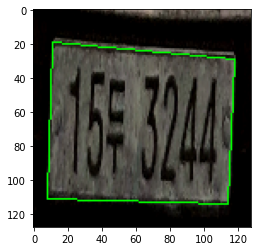

visualizing...


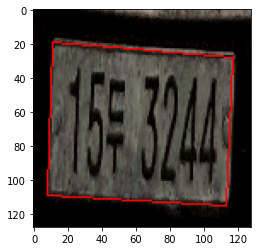

100%|██████████| 26/26 [01:36<00:00,  3.70s/it]

0.010186762868537815
::::Validation::::



  0%|          | 0/7 [00:00<?, ?it/s]

visualizing...


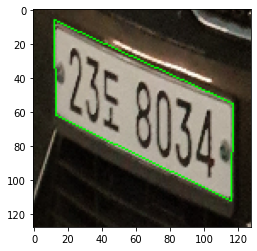

visualizing...


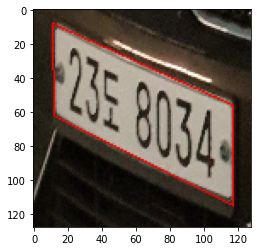

100%|██████████| 7/7 [00:21<00:00,  3.13s/it]

epoch255 end
best : 0.013298273
End


In [8]:
for ep in range(epoch):
    avg_loss = AverageMeter()
    # train
    print("::::Train::::")
    Model.train()
    for idx, i in tqdm(enumerate(train_loader), total = len(train_loader)):
        data_x = i[0].type(torch.float32).cuda()
        data_y = i[1].type(torch.float32).cuda()
        tp = i[2]
        out = Model(data_x)
        out = torch.sigmoid(out)
        loss = criterion(out, data_y)
        avg_loss.update(loss.item(), data_x.shape[0])
        if ep in [1,2,3,4,5,6,7,10, 20, 30, 40, 50, 80, 100, 130, 150, 170, 190, 210, 230, 255] and idx == 0:
            visualization(data_x[0], data_y[0], color=(0, 255, 0))
            visualization(data_x[0], out[0], color=(0, 0, 255))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(avg_loss.avg)
    print("::::Validation::::")
    # evaluation
    correct = 0
    total = 0
    preds = torch.tensor([], dtype=torch.float).cuda()
    gt = torch.tensor([], dtype=torch.float).cuda()
    Model.eval()
    with torch.no_grad():
        # validation code
        for idx, i in tqdm(enumerate(test_loader), total=len(test_loader)):
            data_x = i[0].type(torch.float32).cuda() # (64, 3, 128, 128)
            data_y = i[1].type(torch.float32).cuda() # (64, 8)
            

            out = Model(data_x) # (64, 8)
            out = torch.sigmoid(out) 
            preds = torch.cat((preds, out), 0)
            gt = torch.cat((gt, data_y), 0)
            if ep in [1, 10, 20, 30, 40, 50, 80, 100, 130, 150, 170, 190, 210, 230, 255] and idx == 0:
            
                visualization(data_x[0], data_y[0], color=(0, 255, 0))
                visualization(data_x[0], out[0], color=(0, 0, 255))

        preds = preds.cpu().detach().numpy()
        gt = gt.cpu().detach().numpy()
        rmse = np.sqrt(mean_squared_error(preds, gt))

    if best > rmse:
        print('smaller rmse, saving model weights...')
        print('best: ',best,'current rmse: ',rmse)
        count += 1
        best = rmse
        
        # save
        p = './resnet18_best_random_shear/best'+str(count)+'.pth'
        torch.save(Model,p)
        torch.onnx.export(Model,
                      x,
                      "./onnxfile/resnet18_best_random_shear.onnx",
                      export_params=True, 
                      opset_version=10, # onnx version
                      do_constant_folding=True, 
                      input_names = ['input'],
                      output_names = ['output'], 
                      dynamic_axes={'input' : {0 : 'batch_size'}, 
                                    'output' : {0 : 'batch_size'}}) 

    print('epoch{0} end'.format(ep))
    print('='*100)
    
    
print('best : '+str(best))
print('End')

